In [120]:
import pandas as pd
import numpy as np
from functools import partial

In [121]:
patient_characteristics_train = pd.read_csv('dataset/train/patient_characteristics.csv.gz')
chartevents_train = pd.read_csv('dataset/train/chartevents.csv.gz')
labevents_train = pd.read_csv('dataset/train/labevents.csv.gz')

In [122]:
patient_characteristics_test = pd.read_csv('dataset/test/patient_characteristics.csv.gz')
chartevents_test = pd.read_csv('dataset/test/chartevents.csv.gz')
labevents_test = pd.read_csv('dataset/test/labevents.csv.gz')

# Patient_Characteristics

In [123]:
patient_characteristics_train.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,...,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,371,274,130546,254851,MICU,MICU,12,12,2114-06-28 22:28:44,2114-07-07 18:01:16,...,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,BLACK/AFRICAN AMERICAN,SUBARACHNOID HEMORRHAGE,0
1,379,283,109185,231490,MICU,MICU,15,15,2166-08-12 22:03:26,2166-09-12 14:41:42,...,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,NaN,NaN,WIDOWED,WHITE,PNEUMONIA,0
2,391,291,126219,246725,MICU,MICU,52,52,2107-09-13 22:43:01,2107-09-14 18:34:48,...,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,ALTERED MENTAL STATUS,0
3,408,305,122211,224571,MICU,MICU,50,50,2127-06-19 23:50:45,2127-06-20 18:51:59,...,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,PORT,CATHOLIC,MARRIED,WHITE,CONGESTIVE HEART FAILURE,0
4,409,305,122211,232248,MICU,MICU,50,50,2127-07-03 20:02:34,2127-07-09 15:31:36,...,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,PORT,CATHOLIC,MARRIED,WHITE,CONGESTIVE HEART FAILURE,0


In [124]:
patient_characteristics_train.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_CAREUNIT',
       'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME',
       'LOS', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG'],
      dtype='object')

In [125]:
patient_characteristics_train.shape

(7820, 23)

## Number of HADM & Numer of ICUSTAY

In [126]:
def count_hadm_icustay(df):
    num_hadm = df.groupby('SUBJECT_ID')['HADM_ID'].count().rename('NUM_HADM')
    num_icustays = df.groupby('SUBJECT_ID')['ICUSTAY_ID'].count().rename('NUM_ICUSTAYS')
    
    df = pd.merge(df, num_hadm, on='SUBJECT_ID')
    df = pd.merge(df, num_icustays, on='SUBJECT_ID')
    
    return df

In [127]:
patient_characteristics_train = count_hadm_icustay(patient_characteristics_train)
patient_characteristics_test = count_hadm_icustay(patient_characteristics_test)

## Length of Stay

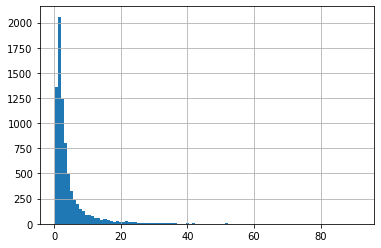

In [128]:
patient_characteristics_train['LOS'].hist(bins=100)

In [129]:
def length_of_stay_quantiles(df, q_locs):
    for i in range(len(q_locs) - 1):
        q = q_locs[i]
        nq = q_locs[i + 1]
        df[f'LOS_q_{q:.2f}'] = df['LOS'].between(q, nq)
        
    return df

In [130]:
q_locs = []
for q in np.linspace(0, 0.8, 4):
    q_loc = patient_characteristics_train['LOS'].quantile(q)
    q_locs.append(q_loc)
    
q_locs.insert(0, 0)
q_locs.append(patient_characteristics_train['LOS'].max())

In [131]:
patient_characteristics_train = length_of_stay_quantiles(patient_characteristics_train, q_locs)
patient_characteristics_test = length_of_stay_quantiles(patient_characteristics_test, q_locs)

# Chartevents

In [132]:
chartevents_train.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,VALUE,NAME
0,85,112077,291697.0,2167-07-26 17:00:00,100.0,heartrate
1,85,112077,291697.0,2167-07-26 18:00:00,106.0,heartrate
2,85,112077,291697.0,2167-07-26 19:00:00,114.0,heartrate
3,85,112077,291697.0,2167-07-26 20:00:00,102.0,heartrate
4,85,112077,291697.0,2167-07-26 21:00:00,111.0,heartrate


In [133]:
quantiles = np.linspace(0.25, 0.75, 3)

quantile_functions = []

for quantile in quantiles:
    qf = partial(np.quantile, q=quantile)
    qf.__name__ = f'q{quantile:.2f}'
    quantile_functions.append(qf)

In [134]:
quantile_functions

[functools.partial(<function quantile at 0x110751320>, q=0.25),
 functools.partial(<function quantile at 0x110751320>, q=0.5),
 functools.partial(<function quantile at 0x110751320>, q=0.75)]

In [171]:
chartevents_train_grouped = chartevents_train.groupby(['ICUSTAY_ID', 'NAME'])['VALUE'].agg(['min', 'max', 'mean', 'std', 'first', 'last', 'count', 'mad', 
                                                    *quantile_functions])

In [172]:
chartevents_test_grouped = chartevents_test.groupby(['ICUSTAY_ID', 'NAME'])['VALUE'].agg(['min', 'max', 'mean', 'std', 'first', 'last', 'count', 'mad', 
                                                    *quantile_functions])

# Labevents

In [173]:
labevents_train.head()

,SUBJECT_ID,HADM_ID,CHARTTIME,VALUE,NAME,ICUSTAY_ID
0,13,143045.0,2167-01-09 20:08:00,7.35,ph,263738.0
1,13,143045.0,2167-01-09 22:05:00,7.33,ph,263738.0
2,13,143045.0,2167-01-09 23:02:00,7.31,ph,263738.0
3,13,143045.0,2167-01-10 00:09:00,7.39,ph,263738.0
4,13,143045.0,2167-01-10 03:26:00,7.33,ph,263738.0


In [174]:
labevents_train_grouped = labevents_train.groupby(['ICUSTAY_ID', 'NAME'])['VALUE'].agg(['min', 'max', 'mean', 'std', 'first', 'last', 'count', 'mad', 
                                                    *quantile_functions])

labevents_test_grouped = labevents_test.groupby(['ICUSTAY_ID', 'NAME'])['VALUE'].agg(['min', 'max', 'mean', 'std', 'first', 'last', 'count', 'mad', 
                                                    *quantile_functions])

In [175]:
def unravel_groups(df):
    df = df.unstack()
    df.columns = ['_'.join(val for val in col) for col in df.columns]
    return df


In [176]:
chartevents_train_grouped = unravel_groups(chartevents_train_grouped)
chartevents_test_grouped = unravel_groups(chartevents_test_grouped)

labevents_train_grouped = unravel_groups(labevents_train_grouped)
labevents_test_grouped = unravel_groups(labevents_test_grouped)

# Merging & Model Preparation

In [375]:
df_model_train = pd.merge(
    pd.merge(chartevents_train_grouped, patient_characteristics_train, on='ICUSTAY_ID'),
    labevents_train_grouped, on='ICUSTAY_ID')

In [376]:
df_model_test = pd.merge(
    pd.merge(chartevents_test_grouped, patient_characteristics_test, on='ICUSTAY_ID'),
    labevents_test_grouped, on='ICUSTAY_ID')

In [377]:
df_model_train.shape, df_model_test.shape

((7820, 250), (1118, 250))

In [378]:
to_drop = ['ROW_ID',
           'SUBJECT_ID',
           'HADM_ID',
           'INTIME',
           'OUTTIME',
           'ADMITTIME',
           'DISCHTIME',
           'DIAGNOSIS']

y_train = df_model_train[['SUBJECT_ID', 'DIAGNOSIS']]
y_test = df_model_test[['SUBJECT_ID', 'DIAGNOSIS']]

df_model_train = df_model_train.drop(to_drop, axis=1)
df_model_test = df_model_test.drop(to_drop, axis=1)

In [379]:
df_model_train.shape, df_model_test.shape

((7820, 242), (1118, 242))

In [380]:
categorical_columns = [
 'ETHNICITY',
 'INSURANCE',
 'RELIGION',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'MARITAL_STATUS',
 'LANGUAGE',
 'FIRST_CAREUNIT',
 'DISCHARGE_LOCATION',
 'FIRST_WARDID',
 'LAST_WARDID',
 'LAST_CAREUNIT']

In [381]:
def to_numeric_df(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    return df

In [382]:
df_model_train = pd.get_dummies(df_model_train, columns=categorical_columns, drop_first=True, dummy_na=True)

df_model_test = pd.get_dummies(df_model_test, columns=categorical_columns, drop_first=True, dummy_na=True)

In [383]:
df_model_train.shape

(7820, 394)

In [384]:
column_intersection = list(set(df_model_train.columns).intersection(set(df_model_test.columns)))

df_model_train = df_model_train[column_intersection]
df_model_test = df_model_test[column_intersection]

In [385]:
df_model_train.shape

(7820, 350)

In [386]:
df_model_train = to_numeric_df(df_model_train)
df_model_test = to_numeric_df(df_model_test)

In [387]:
df_model_train = df_model_train.fillna(df_model_train.mean())

df_model_test = df_model_test.fillna(df_model_test.mean())

# Modelling

In [389]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

X_train = df_model_train.drop('ICUSTAY_ID', axis=1)
X_test = df_model_test.drop('ICUSTAY_ID', axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [392]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train['DIAGNOSIS'])

y_test = encoder.transform(y_test['DIAGNOSIS'])

In [393]:
from sklearn.ensemble import GradientBoostingClassifier

In [394]:
model = GradientBoostingClassifier()

In [395]:
y_train.shape, X_train.shape

((7820,), (7820, 349))

In [396]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [402]:
y_pred = model.predict(X_test)

In [403]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [409]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


cm = pd.DataFrame(confusion_matrix(y_test, y_pred))

cm.columns = encoder.inverse_transform(cm.columns)
cm.index = encoder.inverse_transform(cm.index)

Accuracy: 0.5974955277280859


In [410]:
cm

,ALTERED MENTAL STATUS,CONGESTIVE HEART FAILURE,CORONARY ARTERY DISEASE,DIABETIC KETOACIDOSIS,HYPOTENSION,INTRACRANIAL HEMORRHAGE,PNEUMONIA,SEPSIS,STROKE,SUBARACHNOID HEMORRHAGE
ALTERED MENTAL STATUS,17,7,0,1,0,6,29,21,8,3
CONGESTIVE HEART FAILURE,1,76,7,0,1,0,21,9,0,0
CORONARY ARTERY DISEASE,0,7,246,1,0,0,0,1,0,1
DIABETIC KETOACIDOSIS,2,0,0,31,1,1,4,5,0,0
HYPOTENSION,3,5,1,1,6,1,21,19,1,1
INTRACRANIAL HEMORRHAGE,1,6,1,0,0,46,7,5,7,16
PNEUMONIA,7,21,3,3,2,4,125,34,2,0
SEPSIS,8,8,3,2,7,0,50,77,3,0
STROKE,3,2,0,0,0,20,1,2,14,3
SUBARACHNOID HEMORRHAGE,1,0,0,0,0,20,3,2,3,30
